# Dask Basics

In this notebook we demonstrate some basic features when working with nDimensional array data:

* Dask array - lazy loading
* daskarray.compute()
* daskarray.visulize()
* Diagnostic tool - ProgressBar
* Reduction
---

- Authors: NCI Virtual Research Environment Team
- Keywords: Xarray, Dask, Lazy loading, Diagnostics
- Creation Date: 2020-May
- Lineage/Reference: This tutorial is developed based on [Ryan Abernathey's lecture](https://rabernat.github.io/research_computing_2018/dask-for-parallel-computing-and-big-data.html) and [dask tutorial](https://github.com/dask/dask-tutorial).
---

## Dask

Dask is a parallel computing library that scales the existing Python ecosystem. This tutorial will introduce Dask and parallel data analysis more generally. 

Dask provides multi-core and distributed parallel execution on larger-than-memory datasets. Dask can scale down to your laptop and up to a cluster. 

We can think of Dask at a high and a low level:

**High level collections**: Dask provides high-level Array, Bag, and DataFrame collections that mimic NumPy, lists, and Pandas but can operate in parallel on datasets that don't fit into memory. Dask's high-level collections are alternatives to NumPy and Pandas for large datasets.

**Low Level schedulers**: Dask provides dynamic task schedulers that execute task graphs in parallel. These execution engines power the high-level collections mentioned above but can also power custom, user-defined workloads. These schedulers are low-latency (around 1ms) and work hard to run computations in a small memory footprint. Dask's schedulers are an alternative to direct use of threading or multiprocessing libraries in complex cases or other task scheduling systems like Luigi or IPython parallel.

#### Load the required modules

In [1]:
import xarray as xr
import dask.array as da

Choose from the following two options to create a client:

In [2]:
# If you run this notebook on your local computer or NCI's VDI instance, you can create cluster
from dask.distributed import Client
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:56321' processes=4 threads=8, memory=16.99 GB>


In [ ]:
# If you run this notebook on Gadi under pangeo environment, you can create cluster using scheduler.json file
from dask.distributed import Client, LocalCluster
client = Client(scheduler_file='../scheduler.json')
print(client)

<div class="alert alert-info">
<b>Warning: Please make sure you specify the correct path to the scheduler.json file within your environment.</b>  
</div>

Starting the Dask Client will provide a dashboard which is useful to gain insight into the computation. The link to the dashboard will become visible when you create the Client. We recommend having the Client open on one side of your screen and your notebook open on the other side, which will be useful for learning purposes.

### Dask Arrays

A dask array looks and feels a lot like a numpy array. However, a dask array doesn't directly hold any data. Instead, it symbolically represents the computations needed to generate the data. Nothing is actually computed until the numerical values are needed. This mode of operation is called "lazy"; it allows one to build up complex, large calculations symbolically before turning them over to the scheduler for execution.

In [3]:
shape = (1000, 4000)
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Notice that we just see a symbolic representation of the array, including its shape, dtype, and chunksize. No data has been generated yet. When we call `.compute()` on a dask array, the computation is triggered and the dask array becomes a numpy array.

In [4]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In order to understand what happened when we called `.compute()`, we can visualize the dask graph, the symbolic operations that make up the array.

In [5]:
# Only needed if Graphviz has been installed manually on local PC
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz2.44\\Graphviz\\bin'

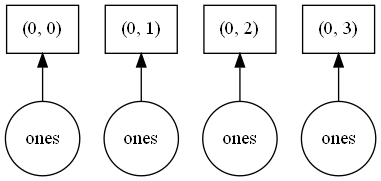

In [6]:
ones.visualize()

Our array has four chunks. To generate it, dask calls np.ones four times and then concatenates them together into one array.

Rather than immediately loading a dask array (which puts all the data into RAM), it is more common to want to reduce the data somehow. For example:

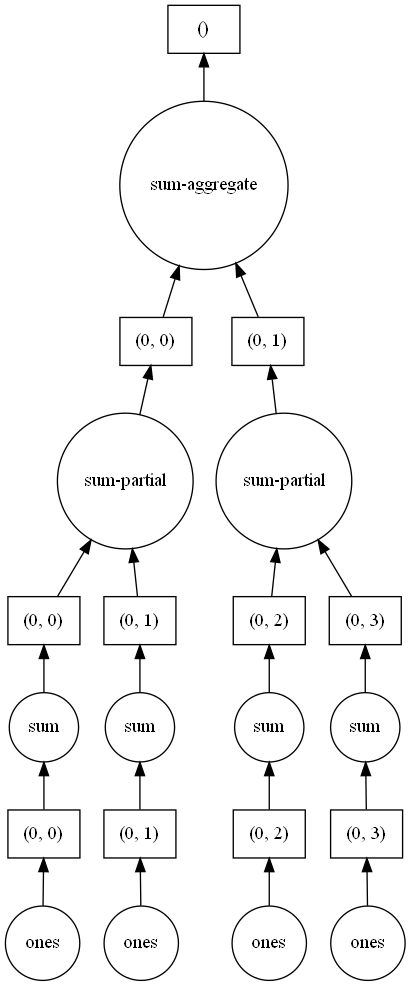

In [7]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

Here we see dask's strategy for finding the sum. This simple example illustrates the beauty of dask: it automatically designs an algorithm appropriate for custom operations with big data.

If we make our operation more complex, the graph gets more complex.

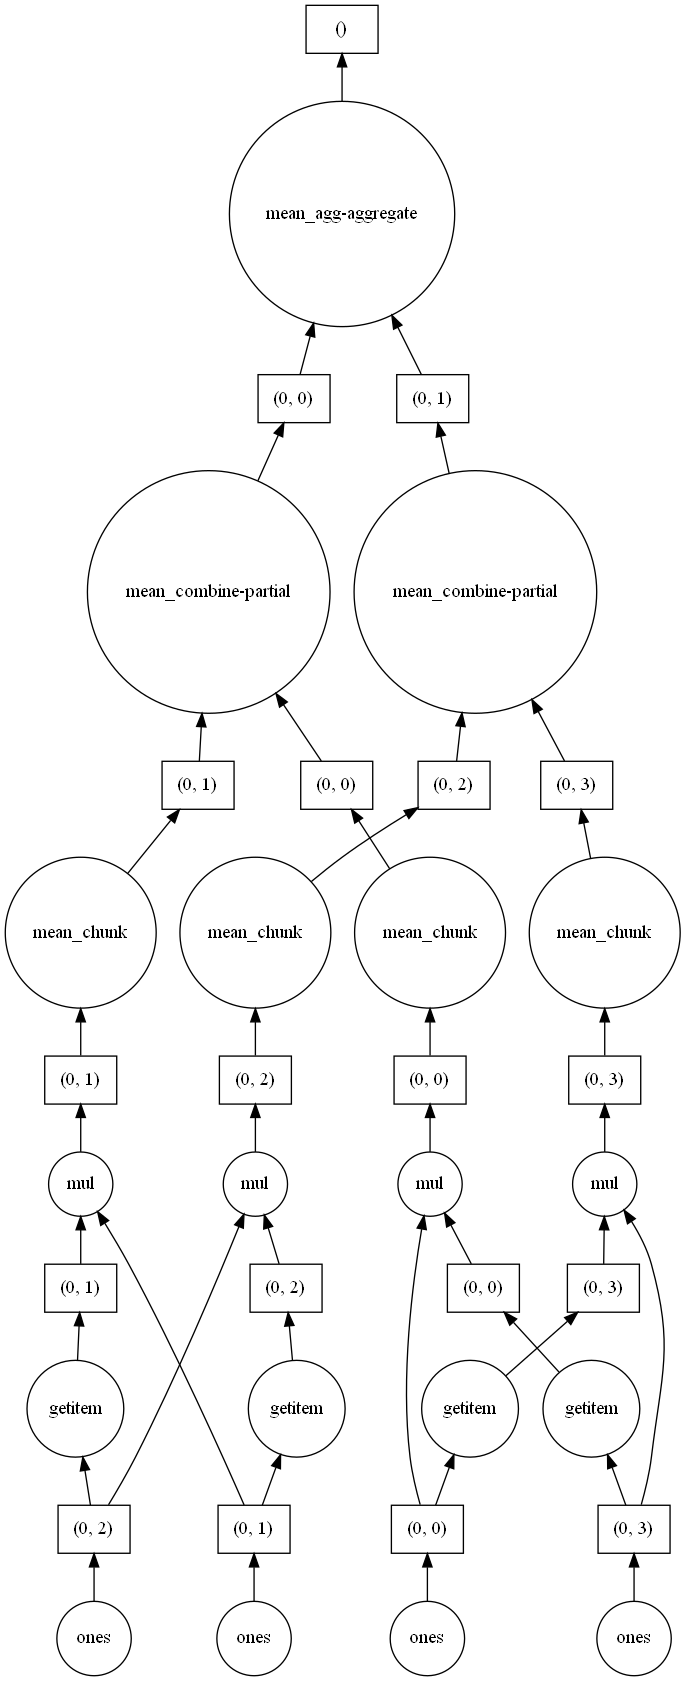

In [8]:
fancy_calculation = (ones * ones[::-1, ::-1]).mean()
fancy_calculation.visualize()

### Monitor large calculations with Progressbar

When running large calculations, Dask also has some tools to help us understand what is happening under the hood.

<div class="alert alert-info">
<b>Warning: </b> Progressbar doesn't work when using a distributed scheduler as the backend. You can run `client.close( )` to close the distributed client. The key difference is that with multi threading/processing, the results are piped back to the control thread, but with distributed, they are calculated asynchronously on the cluster (even if that's on your local machine). 
</div>

In [9]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

from dask.diagnostics import ProgressBar

big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

with ProgressBar():
    result = big_calc.compute()


This dataset requires 3.2 GB of memory which may be close to or greater than the amount of available RAM than you have on your computer. Nevertheless, dask has no problem handling this.

Do not try to .visualize() this array!

When doing a big calculation, Dask also has some tools to help us understand what is happening under the hood.

There are two work arounds:

1. Instead of calling the `ProgressBar` used for local diagnostics, we use the `dask.distributed` `progress` bar. The `progress` function takes a Dask object that is executing in the background:

In [10]:
import time
from dask.distributed import progress

futures = client.map(time.sleep, range(20))
progress(futures)

VBox()

2. To visualize the live progress with `dask.distributed`, you can use Bokeh dashboard on your http://youlocalhost:8787 or the http://localhost:xxxx, in which the port number was created when submitting a PBS job on Gadi under the Pangeo environment. We demonstrate Bokeh dashboard navigation in more detail in a separate tutorial. 

### Reduction

All the usual numpy methods work on dask arrays. You can also apply a numpy function directly to a dask array, and it will stay lazy.

In [11]:
import numpy as np
big_ones_reduce = (np.cos(big_ones)**2).mean(axis=0)
big_ones_reduce

dask.array<mean_agg-aggregate, shape=(4000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:56539 remote=tcp://127.0.0.1:56321>


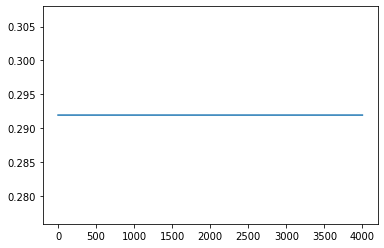

In [13]:
plt.plot(big_ones_reduce)

### Close the client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [14]:
client.close()

### Summary

This example shows some basic concepts of the dask operations .compute(), .visualize() and the diagnostic tool ProgressBar.

## Reference

https://rabernat.github.io/research_computing_2018/dask-for-parallel-computing-and-big-data.html